In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
#from step7.Ecommerce7 import*

### Scenario Recap

In [ ]:
ecomm3_gpts, ecomm3_gpucb, env = observe_learned_functions()
plot_learned_functions(ecomm3_gpts, ecomm3_gpucb, env)

## Step 3

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

In [ ]:
plot_rewards_for_each_experiment(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [14:50<00:00,  8.91s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [08:08<00:00,  4.89s/it]


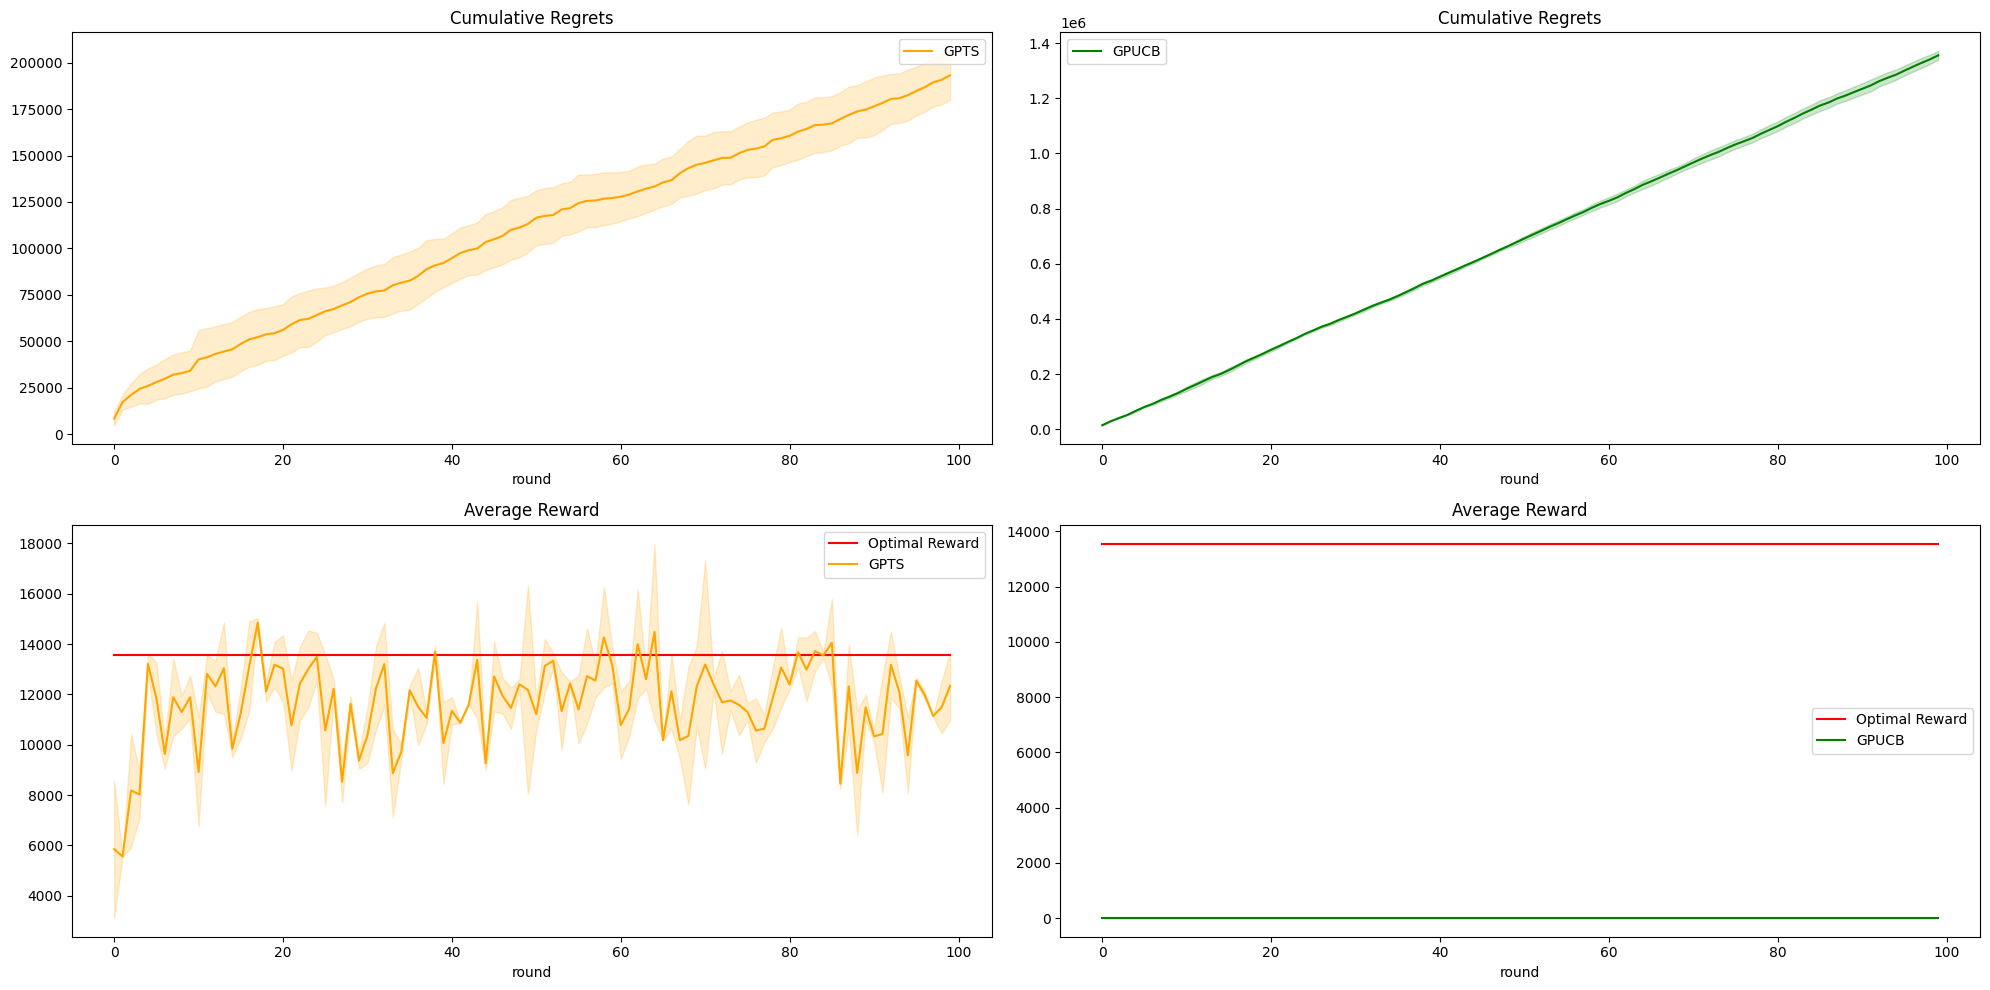

In [3]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

In [ ]:
plot_rewards_for_each_experiment(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

------------------------------------------
best_solution so far:  [1.52852359e-01 6.45012965e+01 2.07451295e-01 2.27888807e+02
 6.25212485e+02]
Minimum rmse: 0.278544
------------------------------------------
------------------------------------------
best_solution so far:  [2.62806144e-01 8.05702277e+01 4.84285317e+01 1.59682975e+02
 3.66152637e+02]
Minimum rmse: 0.235510
------------------------------------------

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

Experiment n° 1


n_iteration: 100%|██████████| 120/120 [07:48<00:00,  3.90s/it]


Experiment n° 2


n_iteration: 100%|██████████| 120/120 [07:47<00:00,  3.90s/it]


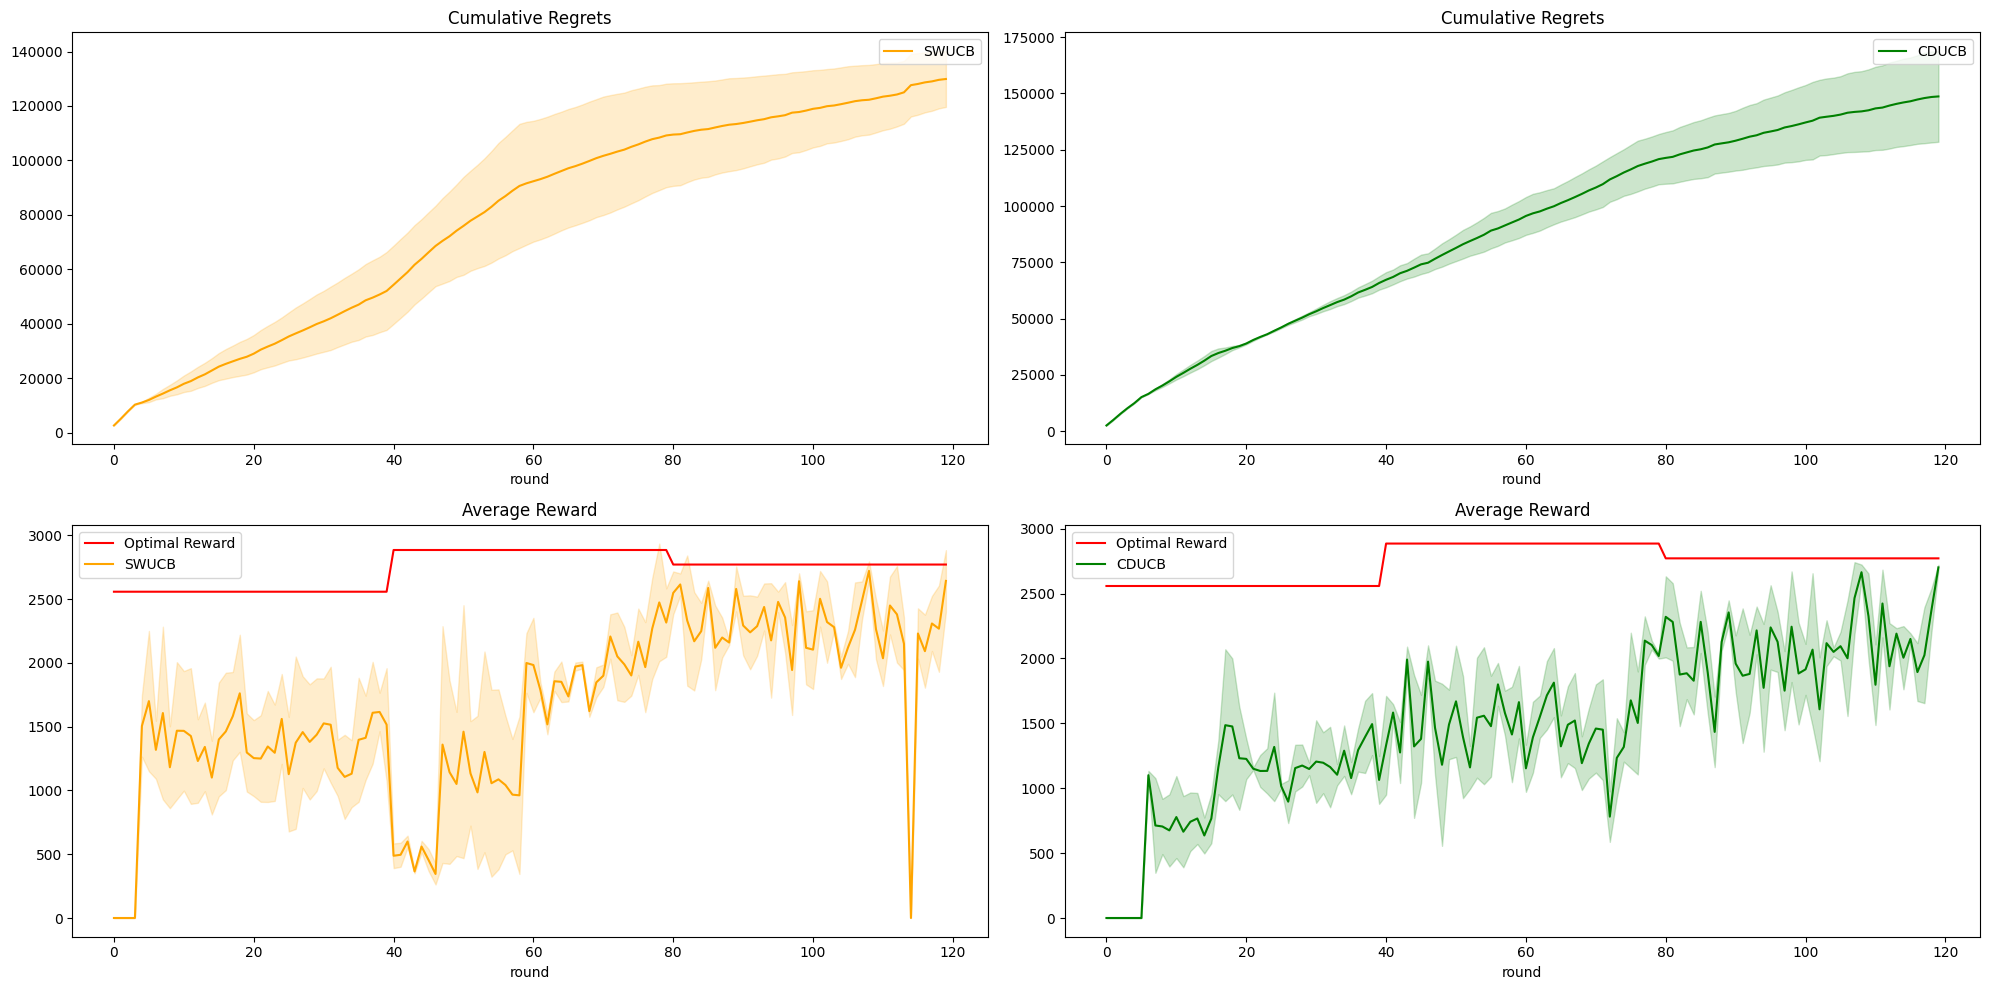

In [3]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, n_phases, phase_len = simulate_step6()
plot_regrets_step6(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"], n_phases, phase_len)

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Hyperparams Tuning

In [13]:
! python gp_parameter_optimizer.py

------------------------------------------
best_solution so far:  [12.0876889]
Minimum rmse: 1.120790
------------------------------------------
^C
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multi